c:\ProgramData\anaconda3\envs\cea\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:
                                             geometry  index_right   blknr  \
47  POLYGON ((384976.272 5820790.551, 384977.076 5...           28  020050   
48  POLYGON ((384977.076 5820789.909, 384980.900 5...           28  020050   
49  POLYGON ((384980.900 5820786.855, 384979.470 5...           28  020050   
50  POLYGON ((384979.470 5820786.297, 384974.776 5...           28  020050   
51  POLYGON ((384974.776 5820780.350, 384974.342 5...           28  020050   

   bez                     bezname       plr blktypname                ewk  \
47  04  Charlottenburg-Wilmersdorf  04300518      Block  100-999 Einwohner   
48  04  Charlottenburg-Wilmersdorf  04300518      Block  100-999 Einwohner   
49  04  Charlottenburg-Wilmersdorf  04300518      Block  100-999 Einwohner   
50  04  Charlottenburg-Wilmersdorf  04300518      Block  100-999 Einwohner   
51  04  Charlottenburg-Wilmersdorf  04300518      Block  100-9

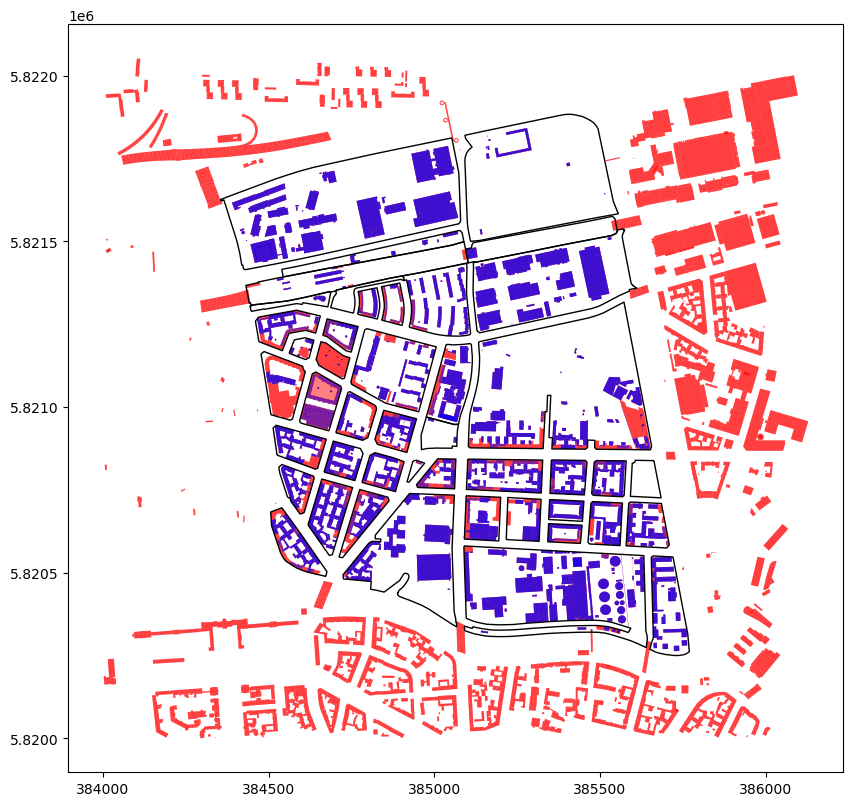

In [2]:
import os
import geopandas as gpd
import pandas as pd
import lxml.etree as ET
import shapely.geometry as geom
import matplotlib.pyplot as plt

# Load shapefile
shapefile_path = r"C:\Users\felix\Programmieren\cea_berlin\auxillary\00_block_shape.shp"
blocks_gdf = gpd.read_file(shapefile_path)

# Load and parse the GML file
gml_files = ["LoD2_33_384_5820_1_BE.xml", "LoD2_33_384_5821_1_BE.xml", "LoD2_33_385_5820_1_BE.xml", "LoD2_33_385_5821_1_BE.xml"]




# Define the namespaces (you may need to adjust these based on your GML file)
ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/2.0'
}

# Extract building geometries
def extract_polygons(gml_root):
    buildings = []

    # Extract posList geometries
    for bldg in gml_root.findall('.//bldg:Building', ns):
        for geom_elem in bldg.findall('.//gml:posList', ns):
            pos_list = geom_elem.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append(polygon)
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    # Extract Polygon geometries
    for poly in gml_root.findall('.//gml:Polygon', ns):
        pos_list = poly.find('.//gml:posList', ns)
        if pos_list is not None:
            pos_list = pos_list.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append(polygon)
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    return buildings

list_buildings = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    #c:\Users\felix\Programmieren\TECDEM\experiments\data\examples\gml_data\gml_data\LoD2_33_384_5820_1_BE.xml
    #C:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\LoD2_33_384_5820_1_BE.xml
    #c:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\gml_data\LoD2_33_384_5820_1_BE.xm 
    tree = ET.parse(gml_file_path)
    root = tree.getroot()
    buildings = extract_polygons(root)
    list_buildings.extend(buildings)

# Check if we have extracted any buildings
if not buildings:
    print("No buildings were extracted from the GML file.")
else:
    # Convert to GeoDataFrame
    buildings_gdf = gpd.GeoDataFrame(geometry=list_buildings, crs=blocks_gdf.crs)

    # Check if buildings are within blocks
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', op='within')

    # Save the result to a CSV file
    aux_path = os.path.join(module_path, 'data', 'examples', 'gml_data', 'buildings_within_blocks.csv')
    within_blocks.to_csv(aux_path, index=False)
    print("The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:")
    print(within_blocks.head())

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()



The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:
                                             geometry  \
47  POLYGON ((384976.272 5820790.551, 384977.076 5...   
48  POLYGON ((384977.076 5820789.909, 384980.900 5...   
49  POLYGON ((384980.900 5820786.855, 384979.470 5...   
50  POLYGON ((384979.470 5820786.297, 384974.776 5...   
51  POLYGON ((384974.776 5820780.350, 384974.342 5...   

                                       gml_id  index_right   blknr bez  \
47  UUID_c4da567a-8e82-4786-998b-b1844cbc20ad           28  020050  04   
48  UUID_58df1d83-84aa-4422-bc1c-6d02f0a67787           28  020050  04   
49  UUID_dcc8e14b-52e0-43ab-9745-fbc404fe980f           28  020050  04   
50  UUID_b567dd6f-fbc8-412a-9b05-82d30ac506ac           28  020050  04   
51  UUID_c0e2a102-56fa-4660-a007-ee292aedb0ee           28  020050  04   

                       bezname       plr blktypname                ewk  \
47  Charlottenburg-Wilmersdorf  04300518      Block  100-99

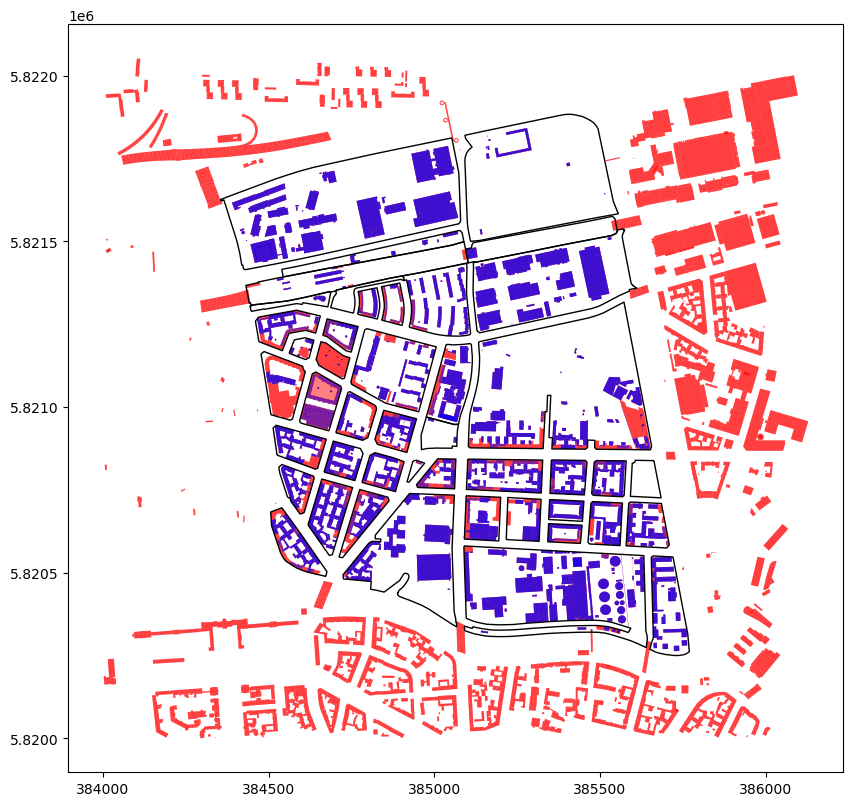

In [3]:
# Extract building geometries along with their IDs

def extract_polygons_with_ids(gml_root):
    buildings = []

    # Extract posList geometries
    for bldg in gml_root.findall('.//bldg:Building', ns):
        bldg_id = bldg.get('{http://www.opengis.net/gml}id')
        for geom_elem in bldg.findall('.//gml:posList', ns):
            pos_list = geom_elem.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append({'geometry': polygon, 'gml_id': bldg_id})
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    # Extract Polygon geometries
    for poly in gml_root.findall('.//gml:Polygon', ns):
        bldg_id = poly.get('{http://www.opengis.net/gml}id')
        pos_list = poly.find('.//gml:posList', ns)
        if pos_list is not None:
            pos_list = pos_list.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append({'geometry': polygon, 'gml_id': bldg_id})
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    return buildings

list_buildings = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    tree = ET.parse(gml_file_path)
    root = tree.getroot()
    buildings = extract_polygons_with_ids(root)
    list_buildings.extend(buildings)  # Use extend to flatten the list

# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs=blocks_gdf.crs)

    # Check if buildings are within blocks
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', predicate='within')

    # Save the result to a CSV file
    aux_path = os.path.join(module_path, 'data', 'examples', 'gml_data', 'buildings_within_blocks.csv')
    within_blocks.to_csv(aux_path, index=False)
    print("The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:")
    print(within_blocks.head())

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()

<Axes: >

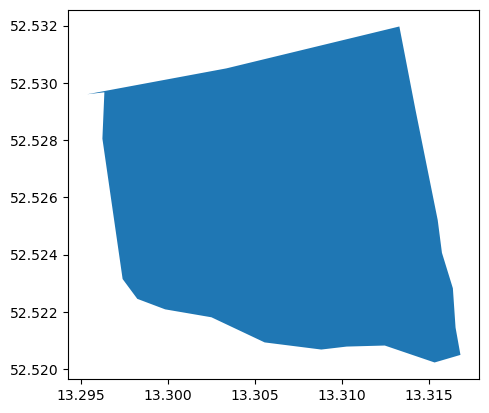

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
# data is obtained from QGIS, the shapefile is a polygon of the Mierendorff island in Berlin
file_path = r'C:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\Mierendorff_shape.shp'
inner_mierendorff = gpd.read_file(file_path)
inner_mierendorff.plot()


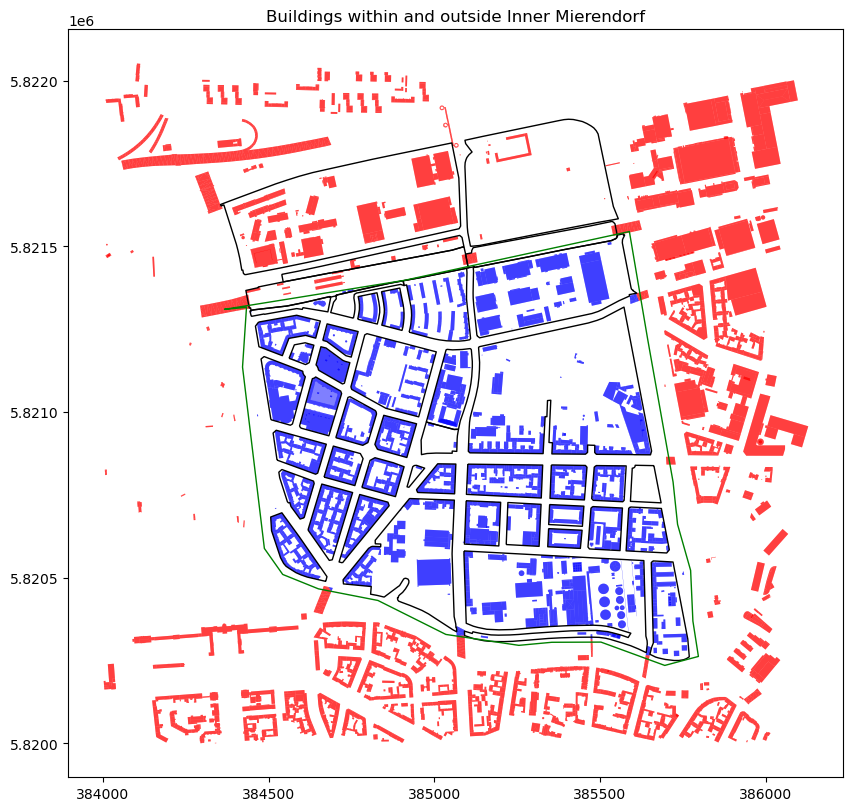

In [5]:

# Perform spatial join to determine which buildings are within inner_mierendorf
inner_mierendorff = inner_mierendorff.to_crs(buildings_gdf.crs)
buildings_within_inner = gpd.sjoin(buildings_gdf, inner_mierendorff, how='inner', predicate='within')

# Create a column to differentiate buildings within and outside inner_mierendorf
buildings_gdf['within_inner'] = buildings_gdf['gml_id'].isin(buildings_within_inner['gml_id'])

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
inner_mierendorff.boundary.plot(ax=ax, linewidth=1, edgecolor='green')

# Plot buildings within inner_mierendorf in blue
buildings_gdf[buildings_gdf['within_inner']].plot(ax=ax, color='blue', alpha=0.5)

# Plot buildings outside inner_mierendorf in red
buildings_gdf[~buildings_gdf['within_inner']].plot(ax=ax, color='red', alpha=0.5)

plt.title('Buildings within and outside Inner Mierendorf')
plt.show()

c:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\LoD2_33_384_5820_1_BE.xml
c:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\LoD2_33_384_5821_1_BE.xml
c:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\LoD2_33_385_5820_1_BE.xml
c:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\LoD2_33_385_5821_1_BE.xml
The result has been saved to 'ground_surfaces_within_blocks.csv'. Here is a preview:
                                              geometry              gml_id  \
6    POLYGON ((384966.710 5820771.741, 384963.836 5...  DEBE3D04YY50000BlO   
79   POLYGON ((385014.416 5820817.572, 385016.053 5...  DEBE3D04YY50000QXO   
125  POLYGON ((384988.955 5820786.719, 384983.965 5...  DEBE3D04YY50000PO8   
859  POLYGON ((385012.684 5820818.988, 385010.874 5...  DEBE3D04YY50000HI4   
927  POLYGON ((385028.771 5820792.408, 385046.427 5...  DEBE3D04YY50000GFg   

     index_right   blknr bez                     bezname       plr blktypname  \
6             28  020050 

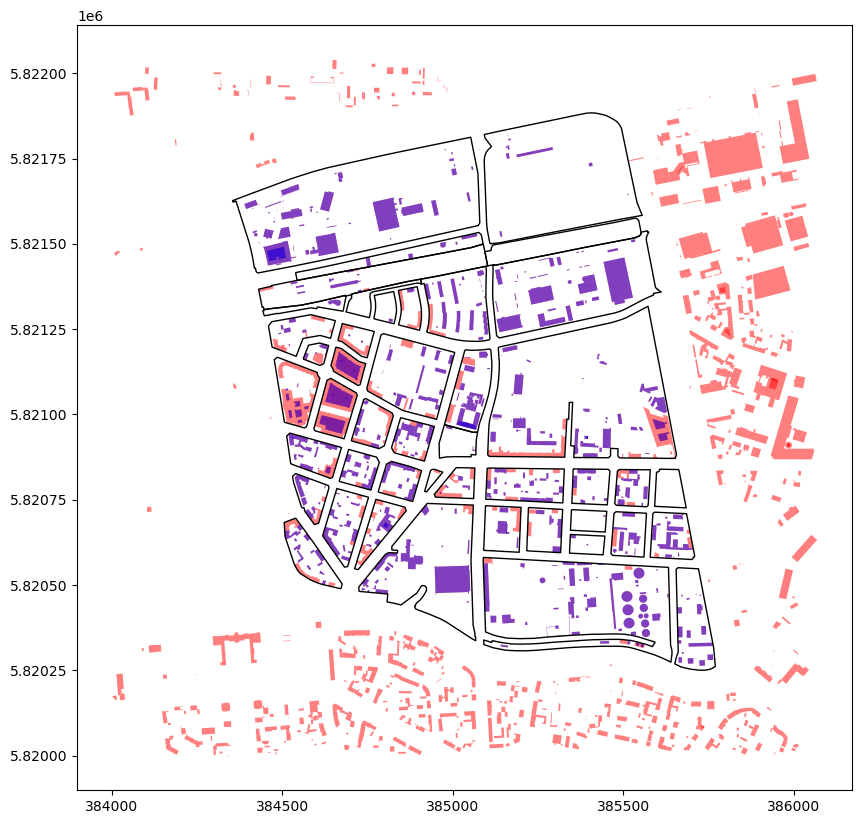

In [6]:
import os
import xml.etree.ElementTree as ET
from shapely import geometry as geom
import geopandas as gpd
import matplotlib.pyplot as plt

# Define namespaces
ns = {
    'bldg': 'http://www.opengis.net/citygml/building/2.0',
    'gml': 'http://www.opengis.net/gml'
}

# Function to extract ground surface geometries along with their IDs
def extract_ground_surfaces_with_ids(gml_root):
    ground_surfaces = []

    
    print(gml_root)
    tree = ET.parse(gml_root)
    root = tree.getroot()
    # Find all buildings and get the data 
    floor_list = []
    for building in root.findall('.//{*}Building'):
        # Get all IDs and yoc 
        building_id = building.get('{http://www.opengis.net/gml}id')
        # 
        gs_node = building.find('.//{*}GroundSurface', ns)
        if gs_node is None:
                print(f"Warning: GroundSurface not found for building {building_id}")

        else:
            pos_tags = gs_node.findall('.//gml:pos', ns)
            if pos_tags:
                    try:
                        polygon_data_str = [pos.text.strip() for pos in pos_tags]
                        polygon_data_flattened = [float(num) for elem in polygon_data_str for num in elem.split()]
                        coords = [(polygon_data_flattened[i], polygon_data_flattened[i+1]) for i in range(0, len(polygon_data_flattened), 3)]
                        polygon = geom.Polygon(coords)
                        ground_surfaces.append({'geometry': polygon, 'gml_id': building_id})
                    except Exception as e:
                        print(f"Error creating polygon for pos: {e}")
            else:
                for geom_elem in gs_node.findall('.//gml:posList', ns):
                    pos_list = geom_elem.text.split()
                    if len(pos_list) % 3 != 0:
                        print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                        continue
                    try:
                        coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                        polygon = geom.Polygon(coords)
                        ground_surfaces.append({'geometry': polygon, 'gml_id': building_id})
                    except Exception as e:
                        print(f"Error creating polygon for posList: {e}")


    return ground_surfaces



# List to hold all extracted ground surfaces
list_ground_surfaces = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    ground_surfaces = extract_ground_surfaces_with_ids(gml_file_path)
    list_ground_surfaces.extend(ground_surfaces)  # Use extend to flatten the list

# Check if we have extracted any ground surfaces
if not list_ground_surfaces:
    print("No ground surfaces were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    ground_surfaces_gdf = gpd.GeoDataFrame(list_ground_surfaces, crs=blocks_gdf.crs)

    # Check if ground surfaces are within blocks
    within_blocks = gpd.sjoin(ground_surfaces_gdf, blocks_gdf, how='inner', predicate='within')

    # Save the result to a CSV file
    aux_path = os.path.join(module_path, 'data', 'examples', 'gml_data', 'ground_surfaces_within_blocks.csv')
    within_blocks.to_csv(aux_path, index=False)
    print("The result has been saved to 'ground_surfaces_within_blocks.csv'. Here is a preview:")
    print(within_blocks.head())

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    ground_surfaces_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()


No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
No GroundSurface found
The result has been saved to 'ground_surfaces_within_blocks.csv'. Here is a preview:
                                                             geometry  \
gml_id                                                                  
DEBE3D00YY1Ha0003w  POLYGON ((384572.590 5820708.222, 384581.810 5...   
DEBE3D

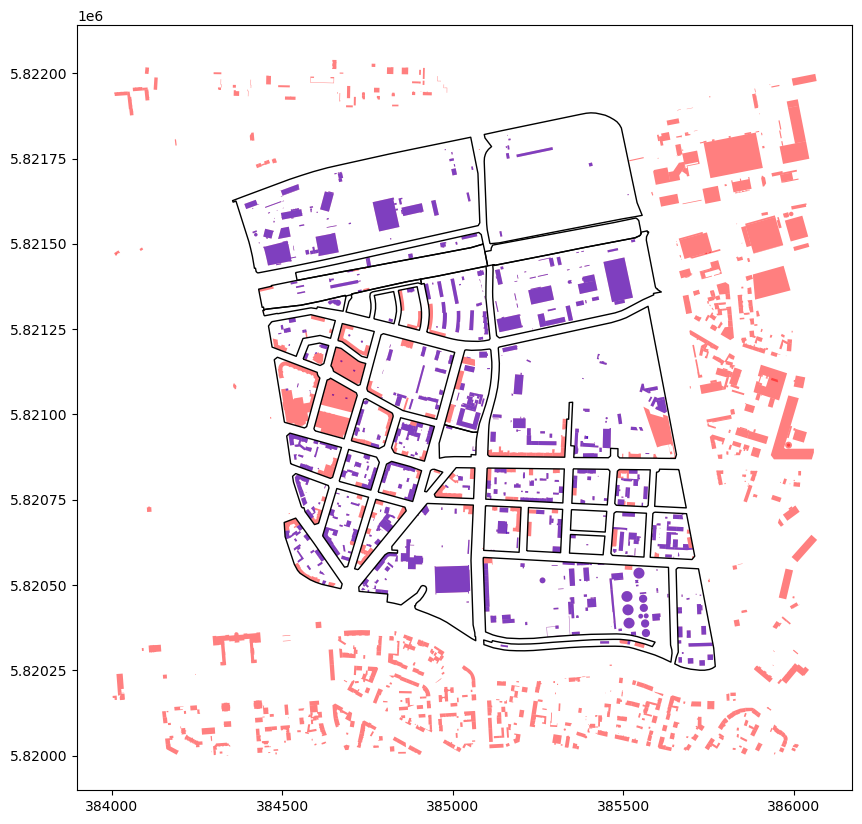

In [13]:
import os
import xml.etree.ElementTree as ET
from shapely import geometry as geom
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

# Define namespaces
ns = {
    'bldg': 'http://www.opengis.net/citygml/building/2.0',
    'gml': 'http://www.opengis.net/gml'
}

# Function to extract ground surface geometries along with their IDs
def extract_ground_surfaces_with_ids(gml_file):
    ground_surfaces = []

    # Parse the GML file
    tree = ET.parse(gml_file)
    root = tree.getroot()

    # Function to process ground surfaces
    def process_ground_surfaces(element, building_id):
        try:
            for gs_node in element.find('.//{*}GroundSurface', ns):
                pos_tags = gs_node.findall('.//gml:pos', ns)
                if pos_tags:
                    try:
                        polygon_data_str = [pos.text.strip() for pos in pos_tags]
                        polygon_data_flattened = [float(num) for elem in polygon_data_str for num in elem.split()]
                        coords = [(polygon_data_flattened[i], polygon_data_flattened[i+1]) for i in range(0, len(polygon_data_flattened), 3)]
                        polygon = geom.Polygon(coords)
                        ground_surfaces.append({'geometry': polygon, 'gml_id': building_id})
                    except Exception as e:
                        print(f"Error creating polygon for pos: {e}")
                else:
                    for geom_elem in gs_node.findall('.//gml:posList', ns):
                        pos_list = geom_elem.text.split()
                        if len(pos_list) % 3 != 0:
                            print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                            continue
                        try:
                            coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                            polygon = geom.Polygon(coords)
                            ground_surfaces.append({'geometry': polygon, 'gml_id': building_id})
                        except Exception as e:
                            print(f"Error creating polygon for posList: {e}")
        except TypeError:
            print("No GroundSurface found")

    # Process buildings and their parts
    for building in root.findall('.//{*}Building'):
        building_id = building.get('{http://www.opengis.net/gml}id')
        process_ground_surfaces(building, building_id)

        # Process building parts
        # That might be the error 
        for part in building.findall('.//bldg:BuildingPart', ns):
            part_id = part.get('{http://www.opengis.net/gml}id')
            process_ground_surfaces(part, part_id)

    return ground_surfaces

# Example usage
list_ground_surfaces = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    ground_surfaces = extract_ground_surfaces_with_ids(gml_file_path)
    list_ground_surfaces.extend(ground_surfaces)  # Use extend to flatten the list

# Check if we have extracted any ground surfaces
if not list_ground_surfaces:
    print("No ground surfaces were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    ground_surfaces_gdf = gpd.GeoDataFrame(list_ground_surfaces, crs=blocks_gdf.crs)

    # Merge ground surfaces by building id
    merged_ground_surfaces = ground_surfaces_gdf.dissolve(by='gml_id')

    # Check if ground surfaces are within blocks
    within_blocks = gpd.sjoin(merged_ground_surfaces, blocks_gdf, how='inner', predicate='within')

    # Save the result to a CSV file
    aux_path = os.path.join(module_path, 'data', 'examples', 'gml_data', 'ground_surfaces_within_blocks.csv')
    within_blocks.to_csv(aux_path, index=False)
    print("The result has been saved to 'ground_surfaces_within_blocks.csv'. Here is a preview:")
    print(within_blocks.head())

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    merged_ground_surfaces.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()


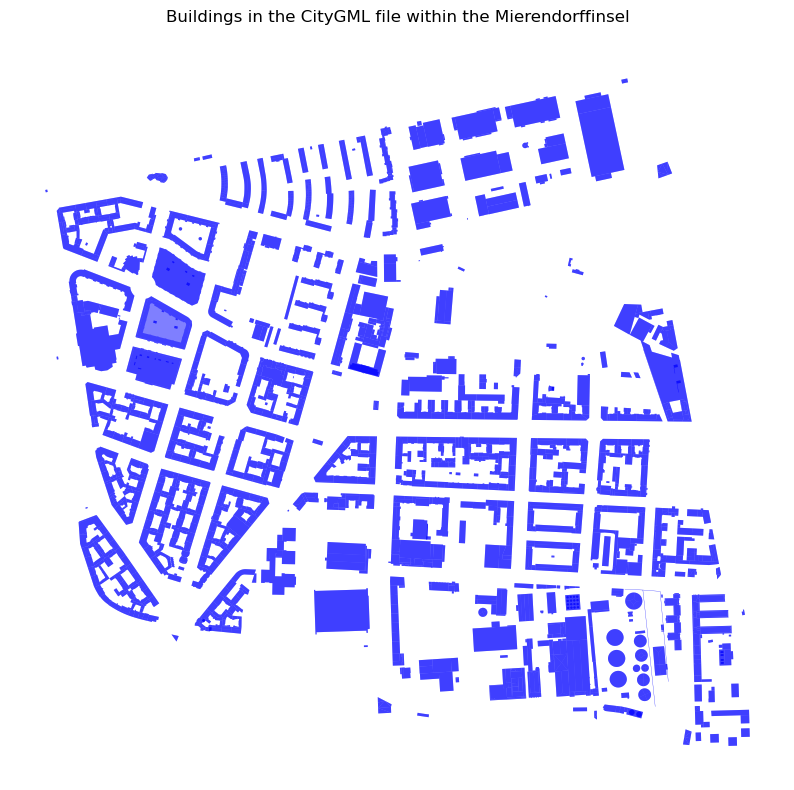

In [11]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
#blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
#inner_mierendorff.boundary.plot(ax=ax, linewidth=1, edgecolor='green')
#buildings_gdf.boundary.plot(ax=ax, color='red', alpha=0.5)

# Plot buildings within inner_mierendorf in blue
buildings_gdf[buildings_gdf['within_inner']].plot(ax=ax, color='blue', alpha=0.5)
ax.axis('off')


plt.title('Buildings in the CityGML file within the Mierendorffinsel')
plt.show()

In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\citygml")

from sheet_generation import create_sheet
from file_handling import get_floor_area
temp_gml_model_sheet = pd.DataFrame()
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    temp_sheet_df = create_sheet(gml_file_path)
    temp_floors = get_floor_area(gml_file_path)
    gml_model_sheet = pd.concat([temp_gml_model_sheet, temp_sheet_df], ignore_index=True)
    


[]
['DEBE3D04YY500004Nu', 'DEBE3D04YY50000R3Q', 'DEBE3D04YY50000BpD', 'DEBE3D04YY50000Dkg', 'DEBE3D04YY50000NHL', 'DEBE3D04YY50000BlO', 'DEBE3D04YY5000039j', 'DEBE3D04YY50000Lta', 'DEBE3D04YY50000Rac', 'DEBE3D04YY50000DpU', 'DEBE3D04YY50000DCT', 'DEBE3D04YY50002d4o', 'DEBE3D04YY50000Lev', 'DEBE3D04YY50000QJa', 'DEBE3D04YY500002JB', 'DEBE3D04YY5000035o', 'DEBE3D04YY50000Neh', 'DEBE3D04YY50000R2f', 'DEBE3D04YY50000Ei2', 'DEBE3D04YY50000EB5', 'DEBE3D04YY50000DSL', 'DEBE3D04YY50000Gm5', 'DEBE3D04YY50000Gdk', 'DEBE3D04YY50000CmK', 'DEBE3D04YY50000IyF', 'DEBE3D04YY500002ZF', 'DEBE3D04YY50000RJm', 'DEBE3D04YY50000AcP', 'DEBE3D04YY50000H3f', 'DEBE3D04YY50000Kt1', 'DEBE3D04YY500000vS', 'DEBE3D04YY50000GXe', 'DEBE3D04YY500005l3', 'DEBE3D04YY50000Nic', 'DEBE3D04YY50000NUq', 'DEBE3D04YY50000Ct5', 'DEBE3D04YY50000Ptt', 'DEBE3D04YY500003MV', 'DEBE3D04YY50000PFP', 'DEBE3D04YY50000N5d', 'DEBE3D00YY1Y50004P', 'DEBE3D04YY50000GJ6', 'DEBE3D04YY50000Peo', 'DEBE3D04YY50002cqa', 'DEBE3D04YY50002bU7', 'DEBE3

In [56]:
def get_3dPosList_from_str(text):
    """
    Function from: https://gitlab.e3d.rwth-aachen.de/e3d-software-tools/cityldt/-/blob/main/string_manipulation.py?ref_type=heads 
    """
    coor_list = [float(x) for x in text.split()]
    coor_list = [list(x) for x in zip(coor_list[0::3], coor_list[1::3], coor_list[2::3])]  # creating 2d coordinate array from 1d array
    return coor_list




def getGroundSurfaceCoorOfBuild(element, nss):
    """returns the ground surface coor form element"""

    # LoD0
    if element:
        for tagName in ['bldg:lod0FootPrint', 'bldg:lod0RoofEdge']:
            LoD_zero_E = element.find(tagName, nss)
            if LoD_zero_E != None:
                posList_E = LoD_zero_E.find('.//{*}gml:posList', nss)
                
                if posList_E != None:
                    return get_3dPosList_from_str(posList_E.text)

                else:                           # case hamburg lod2 2020
                    pos_Es = LoD_zero_E.findall('.//{*}gml:pos', nss)
                    polygon = []
                    for pos_E in pos_Es:
                        polygon.append(pos_E.text)
                    polyStr = ' '.join(polygon)
                    return get_3dPosList_from_str(polyStr)

        groundSurface_E = element.find('.//{*}boundedBy/.//{*}GroundSurface', nss)
        if groundSurface_E != None:
            posList_E = groundSurface_E.find('.//gml:posList', nss)       # searching for list of coordinates

            if posList_E != None:           # case aachen lod2
                return get_3dPosList_from_str(posList_E.text)
                
            else:                           # case hamburg lod2 2020
                pos_Es = groundSurface_E.findall('.//gml:pos', nss)
                polygon = []
                for pos_E in pos_Es:
                    polygon.append(pos_E.text)
                polyStr = ' '.join(polygon)
                return get_3dPosList_from_str(polyStr)
            
            """ 
            gs_node =   element.find('.//{*}GroundSurface', nss)
            if gs_node is not None:
                print(gs_node)
                pos_tags = gs_node.findall('.//{*}gml:pos', nss)
                if pos_tags:
                    print("pos_tags")
                    try:
                        polygon_data_str = [pos.text.strip() for pos in pos_tags]
                        polygon_data_flattened = [float(num) for elem in polygon_data_str for num in elem.split()]
                        coords = [(polygon_data_flattened[i], polygon_data_flattened[i+1]) for i in range(0, len(polygon_data_flattened), 3)]
                        polygon = geom.Polygon(coords)
                        ground_surfaces.append({'geometry': polygon, 'gml_id': building_id})
                    except Exception as e:
                        print(f"Error creating polygon for pos: {e}")
                else:
                    for geom_elem in gs_node.findall('.//{*}posList', ns):
                        pos_list = geom_elem.text.split()
                        if len(pos_list) % 3 != 0:
                            print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                            continue
                        try:
                            coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                            polygon = geom.Polygon(coords)
                            ground_surfaces.append({'geometry': polygon, 'gml_id': building_id})
                        except Exception as e:
                            print(f"Error creating polygon for posList: {e}")
            """
        #  checking if no groundSurface element has been found
        else:               # case for lod1 files
            geometry = element.find('bldg:lod1Solid', nss)
            if geometry != None:
                poly_Es = geometry.findall('.//gml:Polygon', nss)
                all_poylgons = []
                for poly_E in poly_Es:
                    polygon = []
                    posList_E = element.find('.//gml:posList', nss)       # searching for list of coordinates
                    if posList_E != None:
                        polyStr = posList_E.text
                    else:
                        pos_Es = poly_E.findall('.//gml:pos', nss)        # searching for individual coordinates in polygon
                        for pos_E in pos_Es:
                            polygon.append(pos_E.text)
                        polyStr = ' '.join(polygon)
                    coor_list = get_3dPosList_from_str(polyStr)
                    all_poylgons.append(coor_list)
                
                # to get the groundSurface polygon, the average height of each polygon is calculated and the polygon with the lowest average height is considered the groundsurface
                averages = []
                for polygon in all_poylgons:
                    # need to get polygon with lowest z coordinate here
                    average = 0
                    for i in range(len(polygon)-1):
                        average -=- polygon[i][2]
                    averages.append(average/(len(polygon)-1))

                return all_poylgons[averages.index(min(averages))]
            else:
                return ''
    else:
        return ''


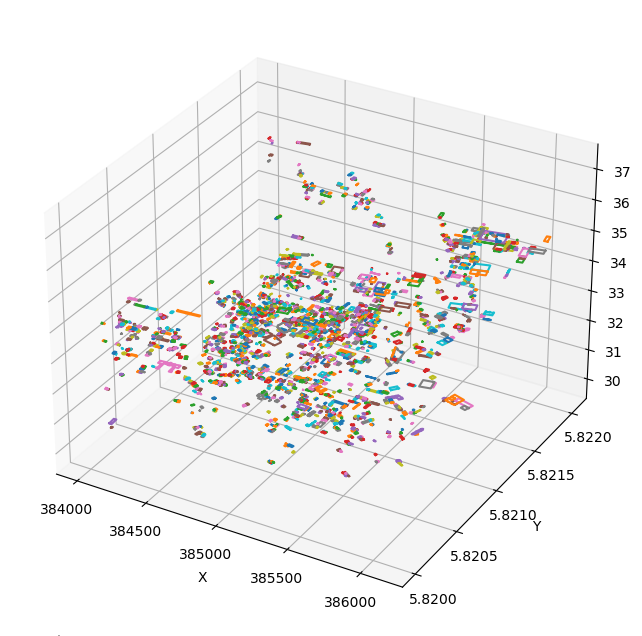

In [67]:
# ToDo - Write function to get building and building part IDs

temp_data = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    tree = ET.parse(gml_file_path)
    root = tree.getroot()
    for building in root.findall('.//{*}Building'):
        building_id = building.get('{http://www.opengis.net/gml}id')
        for co_bp_E in building.findall('.//{*}consistsOfBuildingPart', ns):
            bp_E = co_bp_E.find('.//{*}BuildingPart', ns)
            bp_gC = getGroundSurfaceCoorOfBuild(bp_E, ns)
            building_part_id = bp_E.get('{http://www.opengis.net/gml}id')
            #polygon = geom.Polygon(bp_gC)
            temp_data.append({'geometry': bp_gC, 'gml_id': building_id, "building_part_id": building_part_id})


df = pd.DataFrame(temp_data)

# Function to plot 3D polygons
def plot_3d_polygons(df):
    fig = plt.figure(figsize=(12, 8))  # Increase the size of the plot
    ax = fig.add_subplot(111, projection='3d')
    
    for index, row in df.iterrows():
        coords = row['geometry']
        xs, ys, zs = zip(*coords)
        
        # Close the polygon by repeating the first point
        xs = list(xs) + [xs[0]]
        ys = list(ys) + [ys[0]]
        zs = list(zs) + [zs[0]]
        
        ax.plot(xs, ys, zs, label=f'Building {row["gml_id"]}, Part {row["building_part_id"]}')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Plot the 3D polygons
plot_3d_polygons(df)


<Axes: >

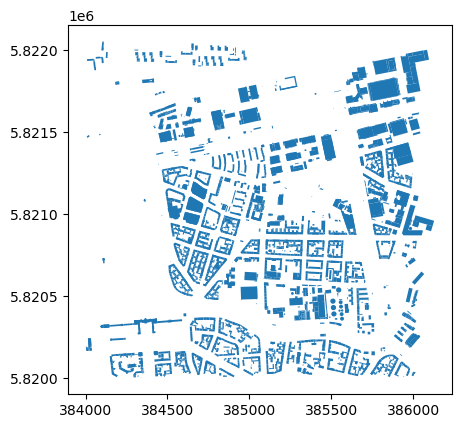

In [133]:
# ToDo - Write function to get building and building part IDs

temp_data = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    tree = ET.parse(gml_file_path)
    root = tree.getroot()
    for building in root.findall('.//{*}Building'):
        building_id = building.get('{http://www.opengis.net/gml}id')
        bp_gC = getGroundSurfaceCoorOfBuild(building, ns)
        bp_gC_2d = [(x, y) for x, y, z in bp_gC]
        polygon = geom.Polygon(bp_gC_2d)
        temp_data.append({
                'geometry': polygon, 
                'coordinates': bp_gC,
                'gml_id': building_id, 
                'building_part_id': ""
            })

        
        for co_bp_E in building.findall('.//{*}consistsOfBuildingPart', ns):
            bp_E = co_bp_E.find('.//{*}BuildingPart', ns)
            bp_gC = getGroundSurfaceCoorOfBuild(bp_E, ns)
            building_part_id = bp_E.get('{http://www.opengis.net/gml}id')
            bp_gC_2d = [(x, y) for x, y, z in bp_gC]
            polygon = geom.Polygon(bp_gC_2d)

            temp_data.append({
                'geometry': polygon, 
                'coordinates': bp_gC,
                'gml_id': building_id, 
                'building_part_id': building_part_id
            })



df = pd.DataFrame(temp_data)


# Optionally, convert the DataFrame to a GeoDataFrame for further spatial analysis
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = "EPSG:25833"


# Plot the valid geometries
gdf[gdf.is_valid].plot(aspect=1)  # Set aspect ratio to 1 or any other positive value

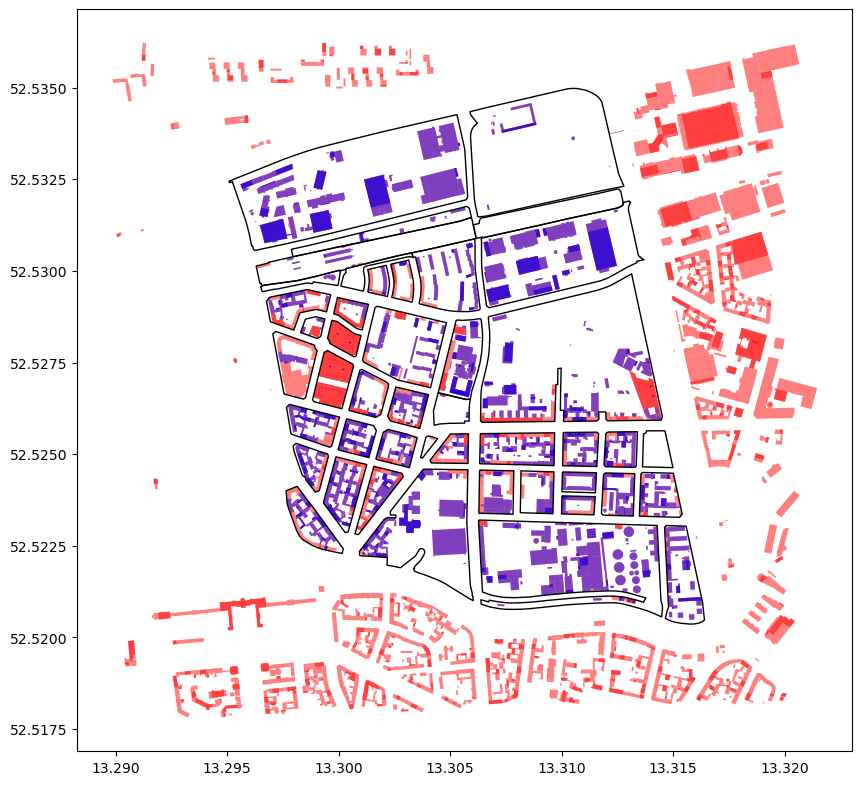

In [134]:

# Check if ground surfaces are within blocks
# Convert gdf to blocks_gdf CRS and filter valid and non-empty geometries
temp_gdf = gdf[gdf.is_valid]
temp_gdf = temp_gdf.to_crs(blocks_gdf.crs)
within_blocks = gpd.sjoin(temp_gdf, blocks_gdf, how='inner', predicate='within')



# Optional: Plotting the results for visual inspection
fig, ax = plt.subplots(figsize=(10, 10))
blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
temp_gdf.plot(ax=ax, color='red', alpha=0.5)

within_blocks[within_blocks.is_valid].plot(ax=ax, color='blue', alpha=0.5)
plt.show()


In [139]:
blocks_gdf

,blknr,bez,bezname,plr,blktypname,ewk,area,datum,geometry
0,019017,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,135480.859375,1999/07/12 00:00:00.000,"POLYGON ((13.30624 52.53147, 13.30611 52.53184..."
1,019033,04,Charlottenburg-Wilmersdorf,04300517,Block,1-9 Einwohner,22794.015625,1996/10/11 00:00:00.000,"POLYGON ((13.30446 52.52668, 13.30526 52.52863..."
2,019609,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,177086.625000,1998/10/08 00:00:00.000,"POLYGON ((13.29619 52.53058, 13.29617 52.53060..."
3,019692,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,96460.437500,2007/05/21 00:00:00.000,"POLYGON ((13.30662 52.52905, 13.30644 52.52989..."
4,019708,04,Charlottenburg-Wilmersdorf,04300518,Block,10-99 Einwohner,16879.630859,2006/03/10 00:00:00.000,"POLYGON ((13.29788 52.53059, 13.29860 52.53069..."
5,019742,04,Charlottenburg-Wilmersdorf,04300518,Block,100-999 Einwohner,183565.937500,2005/02/18 00:00:00.000,"POLYGON ((13.31181 52.52615, 13.31166 52.52615..."
6,019759,04,Charlottenburg-Wilmersdorf,04300517,Block,unbewohnt,8620.879883,1994/11/24 00:00:00.000,"POLYGON ((13.30590 52.52650, 13.30586 52.52633..."
7,019760,04,Charlottenburg-Wilmersdorf,04300517,Block,unbewohnt,1435.945557,1994/11/24 00:00:00.000,"POLYGON ((13.30397 52.52549, 13.30407 52.52549..."
8,019901,04,Charlottenburg-Wilmersdorf,04300518,Bahnblock,unbewohnt,25851.810547,1994/11/24 00:00:00.000,"POLYGON ((13.31266 52.53214, 13.31268 52.53208..."
9,020020,04,Charlottenburg-Wilmersdorf,04300517,Block,unbewohnt,4897.128906,1994/11/24 00:00:00.000,"POLYGON ((13.30008 52.53000, 13.29997 52.52960..."


C:\Users\felix\AppData\Local\Temp\ipykernel_22900\2474627470.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(blocks_gdf.geometry.centroid.x, blocks_gdf.geometry.centroid.y, blocks_gdf.blknr):


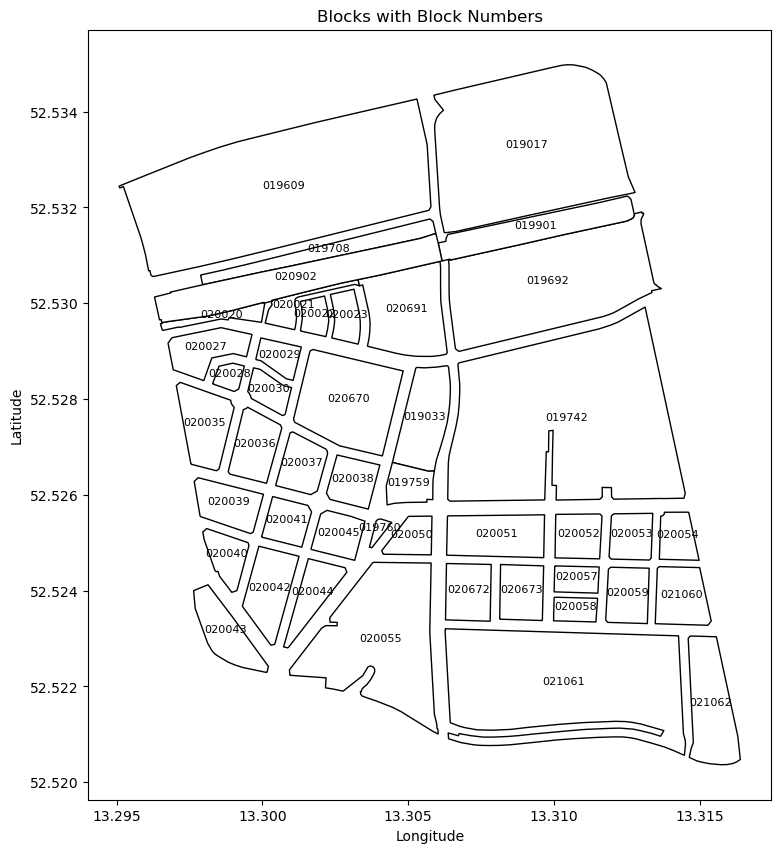

In [145]:
# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
blocks_gdf.plot(ax=ax, color='white', edgecolor='black')

blocks_gdf

# Adding labels
for x, y, label in zip(blocks_gdf.geometry.centroid.x, blocks_gdf.geometry.centroid.y, blocks_gdf.blknr):
    ax.text(x, y, label, fontsize=8, ha='center')

plt.title('Blocks with Block Numbers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Get rid of block 019609, 019017, 09808, 019901, 020902

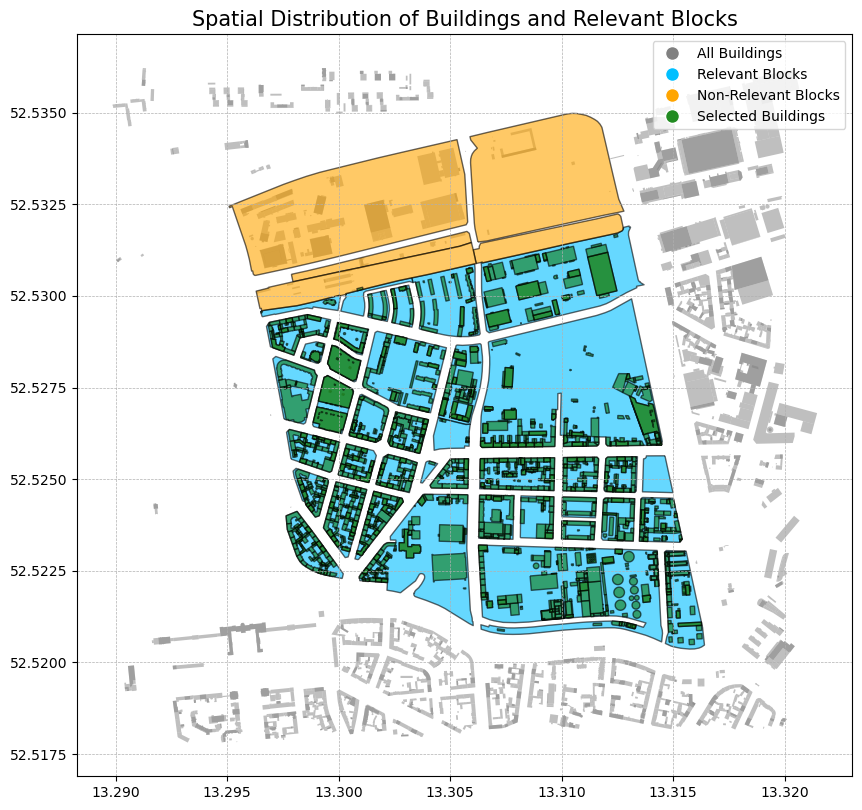

In [156]:
# Check if ground surfaces are within blocks
# Convert gdf to blocks_gdf CRS and filter valid and non-empty geometries
temp_gdf = gdf[gdf.is_valid]
temp_gdf = temp_gdf.to_crs(blocks_gdf.crs)
relevant_blocks = blocks_gdf[~blocks_gdf['blknr'].isin(['019609', '019017', '09808', '019901', '020902', '019708'])]
non_relevant_blocks = blocks_gdf[blocks_gdf['blknr'].isin(['019609', '019017', '09808', '019901', '020902', '019708'])]
within_blocks = gpd.sjoin(temp_gdf, relevant_blocks, how='inner', predicate='intersects')

# Optional: Plotting the results for visual inspection
fig, ax = plt.subplots(figsize=(10, 10))
temp_gdf.plot(ax=ax, color='gray', alpha=0.5)

# Plot relevant blocks
relevant_blocks.plot(ax=ax, color='deepskyblue', edgecolor='black', alpha=0.6, label='Relevant Blocks')

# Plot non-relevant blocks
non_relevant_blocks.plot(ax=ax, color='orange', edgecolor='black', alpha=0.6, label='Non-Relevant Blocks')

# Plot buildings within or intersecting relevant blocks
within_blocks.plot(ax=ax, color='forestgreen', edgecolor='black', alpha=0.6, label='Selected Buildings')

# Add title and labels
ax.set_title('Spatial Distribution of Buildings and Relevant Blocks', fontsize=15)

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='All Buildings'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='deepskyblue', markersize=10, label='Relevant Blocks'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Non-Relevant Blocks'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=10, label='Selected Buildings')]
ax.legend(handles=legend_handles)



# Show plot
plt.show()


In [198]:
# Get number of buildings, where the geometry is not valid
gdf_for_analysis = gdf.to_crs(relevant_blocks.crs)
within_blocks_anaylsis = gpd.sjoin(gdf_for_analysis, relevant_blocks, how='inner', predicate='intersects')
within_blocks_anaylsis.is_valid.value_counts()

True     1897
False       3
Name: count, dtype: int64

In [200]:
within_blocks_anaylsis

,geometry,coordinates,gml_id,building_part_id,index_right,blknr,bez,bezname,plr,blktypname,ewk,area,datum
5,"POLYGON ((1481053.794 6895625.976, 1481055.137...","[[384976.272, 5820790.551, 32.65], [384977.076...",DEBE3D04YY50000BlO,,28,020050,04,Charlottenburg-Wilmersdorf,04300518,Block,100-999 Einwohner,2212.827738,1994/06/01 00:00:00.000
179,"POLYGON ((1481115.313 6895671.877, 1481117.917...","[[385014.416, 5820817.572, 32.036], [385016.05...",DEBE3D04YY50000QXO,,28,020050,04,Charlottenburg-Wilmersdorf,04300518,Block,100-999 Einwohner,469.713114,1994/06/01 00:00:00.000
180,"POLYGON ((1481115.313 6895671.877, 1481117.917...","[[385014.416, 5820817.572, 32.036], [385016.05...",DEBE3D04YY50000QXO,DEBE3DPcFE8lkbYV,28,020050,04,Charlottenburg-Wilmersdorf,04300518,Block,100-999 Einwohner,469.713114,1994/06/01 00:00:00.000
181,"POLYGON ((1481148.232 6895673.241, 1481148.238...","[[385034.496, 5820817.93, 32.036], [385034.49,...",DEBE3D04YY50000QXO,DEBE3DpnBYcjfpwT,28,020050,04,Charlottenburg-Wilmersdorf,04300518,Block,100-999 Einwohner,83.551973,1994/06/01 00:00:00.000
182,"POLYGON ((1481131.472 6895695.127, 1481117.773...","[[385024.595, 5820831.474, 32.036], [385016.24...",DEBE3D04YY50000QXO,DEBE3DwERcC6Wilv,28,020050,04,Charlottenburg-Wilmersdorf,04300518,Block,100-999 Einwohner,385.786252,1994/06/01 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,"POLYGON ((1481299.790 6896372.846, 1481284.698...","[[385136.83, 5821241.012, 33.78], [385128.525,...",DEBE3D04AL2vw0000q,,3,019692,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,7190.413891,2007/05/21 00:00:00.000
3957,"POLYGON ((1481299.790 6896372.846, 1481284.698...","[[385136.83, 5821241.012, 33.78], [385128.525,...",DEBE3D04AL2vw0000q,UUID_ca668bfd-7000-4d83-a899-a88e0bfca2f0,3,019692,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,7190.413891,2007/05/21 00:00:00.000
3958,"POLYGON ((1481346.471 6896365.159, 1481304.116...","[[385165.165, 5821235.672, 33.78], [385139.21,...",DEBE3D04AL2vw0000q,DEBE04AL2vw0000q_01,3,019692,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,799.067444,2007/05/21 00:00:00.000
3959,"POLYGON ((1481344.697 6896372.409, 1481343.530...","[[385164.187, 5821240.104, 33.822], [385163.54...",DEBE3D04AL2vw0000q,DEBE04AL2vw0000q_02,3,019692,04,Charlottenburg-Wilmersdorf,04300518,Block,unbewohnt,17.917087,2007/05/21 00:00:00.000


In [173]:
# Get the number of buildings and building parts
print(f"There are {within_blocks_anaylsis['gml_id'].nunique()} buildings and {within_blocks_anaylsis['building_part_id'].nunique()} building parts")

There are 673 buildings and 1228 building parts


In [204]:
# Get the area in the buildings and building parts
# Change CRS to EPSG:3857 for area calculation in square meters
# Options are 3857, 4326, 4839 (seems most accurate)
within_blocks_anaylsis = within_blocks_anaylsis.to_crs("EPSG:4839")
within_blocks_anaylsis['area'] = within_blocks_anaylsis['geometry'].area
print(f'The full ground surface area of the buildings and building parts is {within_blocks_anaylsis["area"].sum()} square meters')

The full ground surface area of the buildings and building parts is 459063.2496126432 square meters


In [182]:
print(vars(within_blocks_anaylsis.crs))

{'srs': 'EPSG:25833', '_local': <pyproj.crs.crs.CRSLocal object at 0x00000201BEBFEFA0>}


In [ ]:
def get_ids(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Find all buildings at LoD3
    buildings = root.findall('.//bldg:Building', ns)
    print(buildings)
    gml_ids = []
    for building in root.findall('.//{*}Building'):
            # Get all IDs 
            gml_ids.append(building.get('{http://www.opengis.net/gml}id'))
    return gml_ids 

,gml_id,dg_id,address,building_type_gml,year_of_construction,renovation_status,floor_area,height,storeys_above_ground,average_floor_height
0,DEBE3D04YY50000QZa,0,"Germany,Berlin,Charlottenburg-Wilmersdorf",31001_2143,,,82.536377,5.939,NaN,2.8
1,DEBE3D04YY500007XO,1,"Germany,Berlin,Charlottenburg-Wilmersdorf,Kepl...",31001_2200,,,476.463135,9.933,NaN,2.8
2,DEBE3D04YY500003Z4,2,"Germany,Berlin,Charlottenburg-Wilmersdorf,Gauß...",31001_2143,,,265.598145,8.727,NaN,2.8
3,DEBE3D04YY500005hc,3,"Germany,Berlin,Charlottenburg-Wilmersdorf,Gauß...",31001_2020,,,295.940186,8.196,NaN,2.8
4,DEBE3D04YY500006ii,4,"Germany,Berlin,Charlottenburg-Wilmersdorf",31001_2143,,,114.623291,3.014,NaN,2.8
...,...,...,...,...,...,...,...,...,...,...
301,DEBE3D01YYK0002SZd,301,"Germany,Berlin,Mitte",31001_2100,,,36.029541,5.269,NaN,2.8
302,DEBE3DATKB100008KP,302,NaN,53001_1800,,,NaN,1.000,NaN,2.8
303,DEBE3DATKB100008DC,303,NaN,53001_1800,,,NaN,1.000,NaN,2.8
304,DEBE3DATKB100008KY,304,NaN,53001_1800,,,NaN,1.000,NaN,2.8
